In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.experimental import enable_iterative_imputer
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Load the cleaned datasets
train_clean = pd.read_csv('dataset/train_cleaned.csv')
test_clean = pd.read_csv('dataset/test_cleaned.csv')

### Missing value imputation

#### Temperature

In [7]:
train_clean.isna().sum()

id                       0
temperature            972
irradiance             985
humidity               120
panel_age              981
maintenance_count     1003
soiling_ratio          991
voltage                970
current                954
module_temperature     962
cloud_coverage         974
wind_speed             114
pressure               134
string_id                0
error_code            5795
installation_type     4920
efficiency               0
dtype: int64

In [8]:
# Count missing values
missing_temp = train_clean['temperature'].isna()
missing_module_temp = train_clean['module_temperature'].isna()

# Check overlap
both_missing = missing_temp & missing_module_temp
only_temp_missing = missing_temp & (~missing_module_temp)
only_module_missing = (~missing_temp) & missing_module_temp

print(f"Total rows with missing temperature: {missing_temp.sum()}")
print(f"Total rows with missing module_temperature: {missing_module_temp.sum()}")
print(f"Rows where BOTH are missing: {both_missing.sum()}")
print(f"Rows where ONLY temperature is missing: {only_temp_missing.sum()}")
print(f"Rows where ONLY module_temperature is missing: {only_module_missing.sum()}")

Total rows with missing temperature: 972
Total rows with missing module_temperature: 962
Rows where BOTH are missing: 31
Rows where ONLY temperature is missing: 941
Rows where ONLY module_temperature is missing: 931


In [9]:
from sklearn.linear_model import LinearRegression

# Function to impute one column from another using regression
def impute_from_another(df, target_col, predictor_col):
    df_copy = df.copy()
    
    # Prepare training data
    train = df_copy[df_copy[target_col].notna() & df_copy[predictor_col].notna()]
    model = LinearRegression()
    model.fit(train[[predictor_col]], train[target_col])

    # Predict missing values
    missing_mask = df_copy[target_col].isna() & df_copy[predictor_col].notna()
    predicted_values = model.predict(df_copy.loc[missing_mask, [predictor_col]])
    
    # Fill missing values
    df_copy.loc[missing_mask, target_col] = predicted_values
    print(f"Imputed {missing_mask.sum()} missing values in '{target_col}' using '{predictor_col}'")

    return df_copy

# First impute temperature from module_temperature
df = impute_from_another(train_clean, 'temperature', 'module_temperature')
test_df = impute_from_another(test_clean, 'temperature', 'module_temperature')

# Then impute module_temperature from temperature (if needed)
df = impute_from_another(df, 'module_temperature', 'temperature')
test_df = impute_from_another(test_df, 'module_temperature', 'temperature')

Imputed 941 missing values in 'temperature' using 'module_temperature'
Imputed 541 missing values in 'temperature' using 'module_temperature'
Imputed 931 missing values in 'module_temperature' using 'temperature'
Imputed 537 missing values in 'module_temperature' using 'temperature'


In [10]:
df.isna().sum()

id                       0
temperature             31
irradiance             985
humidity               120
panel_age              981
maintenance_count     1003
soiling_ratio          991
voltage                970
current                954
module_temperature      31
cloud_coverage         974
wind_speed             114
pressure               134
string_id                0
error_code            5795
installation_type     4920
efficiency               0
dtype: int64

In [11]:
corr = df[['temperature', 'module_temperature']].corr().iloc[0, 1]
print(f"Correlation between temperature and module_temperature: {corr:.4f}")

Correlation between temperature and module_temperature: 0.9719


In [12]:
df[df['irradiance'].isna()]

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type,efficiency
12,12,2.682375,NaN,16.319750,11.084578,4.0,0.782356,20.927677,1.861089,8.004642,15.243883,0.467009,1016.505323,B2,E02,NaN,0.576775
31,31,1.348561,NaN,98.595111,0.221669,7.0,0.459757,0.000000,1.237910,9.558745,77.078146,1.150128,1013.048070,B2,E02,dual-axis,0.511868
40,40,47.973606,NaN,22.058749,16.093618,4.0,0.428969,47.819612,3.264913,52.238395,80.213642,2.785403,NaN,B2,E01,tracking,0.515999
68,68,29.307608,NaN,99.898344,1.732981,3.0,0.468616,21.474244,1.247087,36.027634,65.807281,7.651904,1011.861027,D4,NaN,dual-axis,0.484732
168,169,15.546451,NaN,48.107634,13.902809,2.0,0.716255,41.747717,1.002628,23.726328,71.205079,14.211828,1008.848629,C3,E01,NaN,0.527169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19480,19938,24.427234,NaN,77.702432,4.047269,5.0,0.466077,13.701232,3.211816,29.662117,73.437600,8.229808,1015.616723,C3,E01,fixed,0.000000
19491,19949,38.850955,NaN,39.843715,8.457577,3.0,0.508990,NaN,NaN,44.613603,94.762371,11.281793,998.887874,C3,NaN,fixed,0.488913
19495,19953,14.976377,NaN,90.535240,13.823331,2.0,0.930509,9.106015,1.084803,17.341767,9.478544,0.060479,1007.823292,B2,NaN,tracking,0.650654
19509,19967,20.422967,NaN,90.701671,23.983481,4.0,0.893158,44.418868,1.913165,30.382020,NaN,0.424010,1019.911345,D4,E01,tracking,0.635271


MICE imputer for irradiance, voltage, current, panel age, cloud coverage, maintanence count

In [13]:
from sklearn.experimental import enable_iterative_imputer  # Needed to enable IterativeImputer
from sklearn.impute import IterativeImputer
import pandas as pd

# List of columns to apply MICE on
mice_cols = ['irradiance', 'voltage', 'current', 'panel_age', 'cloud_coverage', 'maintenance_count','soiling_ratio']

# Subset of the dataframe to impute
mice_data = df[mice_cols]
mice_data_test = test_df[mice_cols]

# Create the imputer
mice_imputer = IterativeImputer(random_state=42, max_iter=10, sample_posterior=False)

# Fit and transform
mice_imputed_array = mice_imputer.fit_transform(mice_data)
mice_imputed_array_test = mice_imputer.transform(mice_data_test)

# Convert back to DataFrame
mice_imputed_df = pd.DataFrame(mice_imputed_array, columns=mice_cols, index=df.index)
mice_imputed_df_test = pd.DataFrame(mice_imputed_array_test, columns=mice_cols, index=test_df.index)

# Replace the original columns in df with the imputed ones
df[mice_cols] = mice_imputed_df
test_df[mice_cols] = mice_imputed_df_test

print(f"MICE imputation completed on columns: {', '.join(mice_cols)}")

MICE imputation completed on columns: irradiance, voltage, current, panel_age, cloud_coverage, maintenance_count, soiling_ratio


In [14]:
df.isna().sum()

id                       0
temperature             31
irradiance               0
humidity               120
panel_age                0
maintenance_count        0
soiling_ratio            0
voltage                  0
current                  0
module_temperature      31
cloud_coverage           0
wind_speed             114
pressure               134
string_id                0
error_code            5795
installation_type     4920
efficiency               0
dtype: int64

In [15]:
from sklearn.impute import KNNImputer
import pandas as pd

# Columns to apply KNN imputer on
knn_cols = ['wind_speed', 'pressure', 'temperature', 'module_temperature', 'humidity']

# Subset the data
knn_data = df[knn_cols]
knn_data_test = test_df[knn_cols]

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')  # You can change n_neighbors if needed

# Fit and transform the data
knn_imputed_array = knn_imputer.fit_transform(knn_data)
knn_imputed_array_test = knn_imputer.transform(knn_data_test)

# Convert to DataFrame and update original df
knn_imputed_df = pd.DataFrame(knn_imputed_array, columns=knn_cols, index=df.index)
knn_imputed_df_test = pd.DataFrame(knn_imputed_array_test, columns=knn_cols, index=test_df.index)
df[knn_cols] = knn_imputed_df
test_df[knn_cols] = knn_imputed_df_test

print(f"KNN imputation completed on columns: {', '.join(knn_cols)}")


KNN imputation completed on columns: wind_speed, pressure, temperature, module_temperature, humidity


In [16]:
df.isna().sum()

id                       0
temperature              0
irradiance               0
humidity                 0
panel_age                0
maintenance_count        0
soiling_ratio            0
voltage                  0
current                  0
module_temperature       0
cloud_coverage           0
wind_speed               0
pressure                 0
string_id                0
error_code            5795
installation_type     4920
efficiency               0
dtype: int64

In [17]:
df['error_code'] = df['error_code'].fillna('NO_ERROR')
test_df['error_code'] = test_df['error_code'].fillna('NO_ERROR')

In [18]:
# Get mode (most frequent value)
mode_installation_type = df['installation_type'].mode()[0]

# Fill missing values with mode
df['installation_type'] = df['installation_type'].fillna(mode_installation_type)
test_df['installation_type'] = test_df['installation_type'].fillna(mode_installation_type)

In [19]:
df.isna().sum()

id                    0
temperature           0
irradiance            0
humidity              0
panel_age             0
maintenance_count     0
soiling_ratio         0
voltage               0
current               0
module_temperature    0
cloud_coverage        0
wind_speed            0
pressure              0
string_id             0
error_code            0
installation_type     0
efficiency            0
dtype: int64

In [20]:
test_df.isna().sum()

id                    0
temperature           0
irradiance            0
humidity              0
panel_age             0
maintenance_count     0
soiling_ratio         0
voltage               0
current               0
module_temperature    0
cloud_coverage        0
wind_speed            0
pressure              0
string_id             0
error_code            0
installation_type     0
dtype: int64

In [21]:
df.sample(10)

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type,efficiency
1042,1070,13.284596,450.778575,4.415897,17.484862,7.0,0.582269,26.534158,1.371667,15.598861,49.792056,6.131053,996.730814,D4,NO_ERROR,dual-axis,0.570781
12542,12832,35.428204,313.065801,74.256101,6.490221,2.0,0.985648,0.000000,0.100993,40.915482,61.453245,2.590135,1001.101947,C3,E00,fixed,0.542499
2651,2728,21.385049,960.313904,47.483663,28.113194,8.0,0.784309,36.949958,1.825094,28.588505,84.206487,1.339198,1014.986451,D4,NO_ERROR,tracking,0.696158
15834,16207,43.454450,427.755430,40.357449,17.466465,5.0,0.826180,9.686164,1.003059,43.303226,54.566432,13.474600,1014.163725,B2,E01,tracking,0.428710
14604,14945,14.619081,197.224852,63.671210,25.952394,4.0,0.963276,6.883776,0.956759,19.153981,61.975273,10.725841,1002.426220,B2,NO_ERROR,dual-axis,0.452289
19451,19909,33.413525,767.705554,72.342286,18.547518,3.0,0.759052,39.109175,2.640419,39.421496,53.464327,6.499965,1033.544466,D4,NO_ERROR,tracking,0.633203
7138,7306,28.375489,510.696866,80.274568,31.901904,9.0,0.533894,16.492340,1.704504,33.394051,73.584045,6.741528,1014.526042,A1,E00,tracking,0.401524
4808,4927,36.124067,580.727308,56.088166,6.809690,2.0,0.633000,24.880556,2.464879,38.875587,60.132926,12.420366,1021.024069,D4,NO_ERROR,tracking,0.447239
13097,13405,10.522163,171.024554,17.375354,33.086784,0.0,0.799123,24.635378,0.909412,13.683558,64.718394,14.603295,1017.441054,D4,E00,tracking,0.454739
8122,8319,20.030728,632.138371,57.882277,10.170918,3.0,0.699491,2.318598,1.486248,24.733744,85.009219,0.396551,1020.738658,D4,NO_ERROR,fixed,0.741671


In [22]:
df.describe()

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,efficiency
count,19542.000000,19542.000000,19542.000000,19542.000000,19542.000000,19542.000000,19542.000000,19542.000000,19542.000000,19542.000000,19542.000000,19542.000000,19542.000000,19542.000000
mean,10003.926875,24.904875,514.922185,50.049263,17.503515,4.009304,0.699328,16.445494,1.729406,29.918104,49.754641,7.408708,1012.985282,0.514547
std,5772.075772,11.739286,231.908971,28.634418,9.838813,1.948388,0.167740,17.539145,1.133221,12.099398,28.104190,4.320534,10.012590,0.138346
min,0.000000,-1.345699,0.633327,0.010714,0.001264,0.000000,0.400149,0.000000,0.000054,0.000000,0.000244,0.001277,970.087365,0.000000
25%,5006.250000,16.859068,353.496992,25.366157,9.221110,3.000000,0.559335,0.000000,0.821033,21.551461,26.508603,3.685623,1006.226721,0.450694
50%,10005.500000,24.719956,504.998102,50.223352,17.499696,4.000000,0.699075,13.310627,1.593866,29.858189,49.748436,7.384527,1012.906673,0.518481
75%,14996.750000,32.794953,667.092590,74.371458,25.819418,5.000000,0.839928,26.069038,2.457625,38.089743,73.583077,11.131396,1019.746610,0.592263
max,19999.000000,60.000000,1537.810349,99.995202,34.998379,15.000000,0.999949,494.279016,7.315597,65.071839,99.999267,14.999448,1052.865715,0.987066


In [23]:
df.to_csv('dataset/imputed/train_imputed.csv', index=False)
test_df.to_csv('dataset/imputed/test_imputed.csv', index=False)

### Domain-Specific Feature Creation

In [24]:
def create_solar_features(df):
    """Create domain-specific features for solar panel analysis"""
    df_engineered = df.copy()
    
    # Power calculation (P = V * I)
    if 'voltage' in df.columns and 'current' in df.columns:
        df_engineered['power_output'] = df_engineered['voltage'] * df_engineered['current']
    
    # Temperature difference (module vs ambient)
    if 'module_temperature' in df.columns and 'temperature' in df.columns:
        df_engineered['temp_difference'] = (df_engineered['module_temperature'] - 
                                          df_engineered['temperature'])
    
    # Performance ratio (considering irradiance and temperature effects)
    if 'irradiance' in df.columns and 'temperature' in df.columns:
        # Normalized irradiance (relative to standard test conditions: 1000 W/m²)
        df_engineered['irradiance_normalized'] = df_engineered['irradiance'] / 1000
        
        # Temperature coefficient effect (typical -0.4%/°C)
        df_engineered['temp_coefficient_effect'] = 1 - 0.004 * (df_engineered['temperature'] - 25)
    
    # Soiling impact on expected performance
    if 'soiling_ratio' in df.columns and 'irradiance' in df.columns:
        df_engineered['expected_irradiance_clean'] = (df_engineered['irradiance'] / 
                                                     df_engineered['soiling_ratio'])
        df_engineered['soiling_loss'] = (df_engineered['expected_irradiance_clean'] - 
                                        df_engineered['irradiance'])
    
    # Weather interaction features
    if 'cloud_coverage' in df.columns and 'irradiance' in df.columns:
        df_engineered['irradiance_cloud_ratio'] = (df_engineered['irradiance'] / 
                                                  (100 - df_engineered['cloud_coverage'] + 1))
    
    # Aging effects
    if 'panel_age' in df.columns:
        # Typical degradation rate: 0.5-0.8% per year
        df_engineered['age_degradation_factor'] = 1 - (0.006 * df_engineered['panel_age'])
        df_engineered['age_category'] = pd.cut(df_engineered['panel_age'], 
                                              bins=[0, 2, 5, 10, float('inf')],
                                              labels=['New', 'Young', 'Mature', 'Old'])
    
    # Maintenance effectiveness
    if 'maintenance_count' in df.columns and 'panel_age' in df.columns:
        df_engineered['maintenance_frequency'] = (df_engineered['maintenance_count'] / 
                                                 (df_engineered['panel_age'] + 1))
    
    # Environmental stress factors
    if 'humidity' in df.columns and 'temperature' in df.columns:
        # Heat index approximation
        df_engineered['environmental_stress'] = (df_engineered['humidity'] * 
                                               df_engineered['temperature'] / 100)
    
    # Wind cooling effect
    if 'wind_speed' in df.columns and 'module_temperature' in df.columns:
        df_engineered['wind_cooling_effect'] = df_engineered['wind_speed'] * 2  # Simplified model
        df_engineered['effective_module_temp'] = (df_engineered['module_temperature'] - 
                                                 df_engineered['wind_cooling_effect'])
    
    return df_engineered

# Apply feature engineering
train_engineered = create_solar_features(df)
test_engineered = create_solar_features(df)

print("New features created:")
new_features = set(train_engineered.columns) - set(df.columns)
for feature in new_features:
    print(f"- {feature}")

New features created:
- age_category
- soiling_loss
- temp_coefficient_effect
- temp_difference
- expected_irradiance_clean
- irradiance_cloud_ratio
- effective_module_temp
- wind_cooling_effect
- power_output
- maintenance_frequency
- irradiance_normalized
- environmental_stress
- age_degradation_factor


In [25]:
train_engineered

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,...,temp_coefficient_effect,expected_irradiance_clean,soiling_loss,irradiance_cloud_ratio,age_degradation_factor,age_category,maintenance_frequency,environmental_stress,wind_cooling_effect,effective_module_temp
0,0,7.817315,576.179270,41.243087,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,...,1.068731,717.355436,141.176166,14.963381,0.807187,Old,0.120716,3.224102,25.649824,-11.958677
1,1,24.785727,240.003973,1.359648,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,...,1.000857,500.575786,260.571813,4.199636,0.880135,Old,0.381362,0.336999,24.024087,3.521009
2,2,46.652695,687.612799,91.265368,1.496401,4.0,0.822398,48.222882,4.191800,43.363708,...,0.913389,836.106607,148.493808,13.391385,0.991022,New,1.602307,42.577754,3.628800,39.734909
3,3,53.339567,735.141179,96.190955,18.491582,3.0,0.837529,46.295748,0.960567,57.720436,...,0.886642,877.750499,142.609320,21.854143,0.889051,Old,0.153913,51.307839,17.472518,40.247918
4,4,5.575374,12.241203,27.495073,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,...,1.077699,22.182814,9.941612,0.125721,0.815664,Old,0.189139,1.532953,1.045368,5.740895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19537,19995,16.868428,624.845067,93.530318,14.393967,3.0,0.738911,12.147711,3.005355,26.206810,...,1.032526,845.629465,220.784398,6.294591,0.913636,Old,0.194882,15.777095,25.188245,1.018565
19538,19996,53.415061,296.970303,93.985714,25.997012,2.0,0.513061,0.000000,0.532119,65.000000,...,0.886340,578.820651,281.850348,8.149271,0.844018,Old,0.074082,50.202526,1.953982,63.046018
19539,19997,2.442727,660.328019,37.968918,32.818396,9.0,0.548602,13.047950,4.075498,11.584869,...,1.090229,1203.656537,543.328518,15.260690,0.803090,Old,0.266127,0.927477,9.501874,2.082994
19540,19998,16.660075,632.760700,43.014702,19.063517,4.0,0.700757,0.000000,1.068906,21.149351,...,1.033360,902.967922,270.207222,27.660085,0.885619,Old,0.199367,7.166282,22.608317,-1.458966


In [26]:
# # Drop original columns that are no longer needed -> information is now captured in engineered features

# train_engineered.drop(columns=['id', 'voltage','current', 'temperature','module_temperature', 'irradiance', 'wind_speed', 'panel_age', 'cloud_coverage', 'soiling_ratio', 'maintenance_count', 'humidity'], inplace=True, errors='ignore')
# test_engineered.drop(columns=['id', 'voltage','current', 'temperature','module_temperature', 'irradiance', 'wind_speed', 'panel_age', 'cloud_coverage', 'soiling_ratio', 'maintenance_count', 'humidity'], inplace=True, errors='ignore')

In [27]:
test_engineered

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,...,temp_coefficient_effect,expected_irradiance_clean,soiling_loss,irradiance_cloud_ratio,age_degradation_factor,age_category,maintenance_frequency,environmental_stress,wind_cooling_effect,effective_module_temp
0,0,7.817315,576.179270,41.243087,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,...,1.068731,717.355436,141.176166,14.963381,0.807187,Old,0.120716,3.224102,25.649824,-11.958677
1,1,24.785727,240.003973,1.359648,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,...,1.000857,500.575786,260.571813,4.199636,0.880135,Old,0.381362,0.336999,24.024087,3.521009
2,2,46.652695,687.612799,91.265368,1.496401,4.0,0.822398,48.222882,4.191800,43.363708,...,0.913389,836.106607,148.493808,13.391385,0.991022,New,1.602307,42.577754,3.628800,39.734909
3,3,53.339567,735.141179,96.190955,18.491582,3.0,0.837529,46.295748,0.960567,57.720436,...,0.886642,877.750499,142.609320,21.854143,0.889051,Old,0.153913,51.307839,17.472518,40.247918
4,4,5.575374,12.241203,27.495073,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,...,1.077699,22.182814,9.941612,0.125721,0.815664,Old,0.189139,1.532953,1.045368,5.740895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19537,19995,16.868428,624.845067,93.530318,14.393967,3.0,0.738911,12.147711,3.005355,26.206810,...,1.032526,845.629465,220.784398,6.294591,0.913636,Old,0.194882,15.777095,25.188245,1.018565
19538,19996,53.415061,296.970303,93.985714,25.997012,2.0,0.513061,0.000000,0.532119,65.000000,...,0.886340,578.820651,281.850348,8.149271,0.844018,Old,0.074082,50.202526,1.953982,63.046018
19539,19997,2.442727,660.328019,37.968918,32.818396,9.0,0.548602,13.047950,4.075498,11.584869,...,1.090229,1203.656537,543.328518,15.260690,0.803090,Old,0.266127,0.927477,9.501874,2.082994
19540,19998,16.660075,632.760700,43.014702,19.063517,4.0,0.700757,0.000000,1.068906,21.149351,...,1.033360,902.967922,270.207222,27.660085,0.885619,Old,0.199367,7.166282,22.608317,-1.458966


In [28]:
train_engineered.isna().sum()

id                           0
temperature                  0
irradiance                   0
humidity                     0
panel_age                    0
maintenance_count            0
soiling_ratio                0
voltage                      0
current                      0
module_temperature           0
cloud_coverage               0
wind_speed                   0
pressure                     0
string_id                    0
error_code                   0
installation_type            0
efficiency                   0
power_output                 0
temp_difference              0
irradiance_normalized        0
temp_coefficient_effect      0
expected_irradiance_clean    0
soiling_loss                 0
irradiance_cloud_ratio       0
age_degradation_factor       0
age_category                 0
maintenance_frequency        0
environmental_stress         0
wind_cooling_effect          0
effective_module_temp        0
dtype: int64

In [29]:
train_engineered.to_csv('dataset/train_engineered.csv', index=False)
test_engineered.to_csv('dataset/test_engineered.csv', index=False)
print("Feature engineering completed and saved to 'dataset/train_engineered.csv' and 'dataset/test_engineered.csv'.")

Feature engineering completed and saved to 'dataset/train_engineered.csv' and 'dataset/test_engineered.csv'.


In [33]:
df_engineered = pd.read_csv('dataset/train_engineered.csv')
df_engineered.shape

(19542, 30)

In [34]:
from scipy import stats

# Box-Cox transformations for skewed features
df_engineered['irradiance_boxcox'], _ = stats.boxcox(df_engineered['irradiance'] + 1)
df_engineered['power_output_log'] = np.log1p(df_engineered['power_output'])

# Robust scaling for outlier-prone features
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_engineered['temp_difference_robust'] = scaler.fit_transform(
    df_engineered[['temp_difference']])

# Winsorization for extreme values
df_engineered['irradiance_winsorized'] = np.clip(df_engineered['irradiance'], 
                                                 np.percentile(df_engineered['irradiance'], 1),
                                                 np.percentile(df_engineered['irradiance'], 99))


In [35]:
df_engineered.shape

(19542, 34)

In [37]:
# Theoretical maximum power calculation
df_engineered['theoretical_max_power'] = (df_engineered['irradiance_normalized'] * 
                                         df_engineered['temp_coefficient_effect'] * 
                                         df_engineered['age_degradation_factor'] * 
                                         df_engineered['soiling_ratio'])

# Performance deviation metrics
df_engineered['performance_deviation'] = (df_engineered['power_output'] - 
                                         df_engineered['theoretical_max_power'])
df_engineered['efficiency_ratio'] = (df_engineered['power_output'] / 
                                    df_engineered['theoretical_max_power'])

# String-level aggregations
string_stats = df_engineered.groupby('string_id')['power_output'].agg(['mean', 'std', 'min', 'max'])
string_stats.columns = ['power_output_string_mean', 'power_output_string_std', 
                        'power_output_string_min', 'power_output_string_max']
df_engineered = df_engineered.merge(string_stats, left_on='string_id', right_index=True)
df_engineered['power_vs_string_mean'] = (df_engineered['power_output'] - 
                                        df_engineered['power_output_string_mean'])



In [38]:
# Error frequency and patterns
df_engineered['error_indicator'] = (df_engineered['error_code'] != 0).astype(int)
df_engineered['consecutive_errors'] = df_engineered.groupby('string_id')['error_indicator'].transform(
    lambda x: x.groupby((x != x.shift()).cumsum()).cumsum())

# Performance anomaly detection
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.1)
df_engineered['anomaly_score'] = iso_forest.fit_predict(
    df_engineered[['power_output', 'irradiance', 'module_temperature']])


In [39]:
from sklearn.cluster import KMeans

# Cluster similar operating conditions
features_for_clustering = ['irradiance_normalized', 'temp_difference', 'environmental_stress']
kmeans = KMeans(n_clusters=5, random_state=42)
df_engineered['operating_regime'] = kmeans.fit_predict(df_engineered[features_for_clustering])

# Regime-specific performance metrics
regime_performance = df_engineered.groupby('operating_regime')['power_output'].mean()
df_engineered['regime_expected_power'] = df_engineered['operating_regime'].map(regime_performance)
df_engineered['regime_performance_deviation'] = (df_engineered['power_output'] - 
                                               df_engineered['regime_expected_power'])

In [41]:
df_engineered.columns

Index(['id', 'temperature', 'irradiance', 'humidity', 'panel_age',
       'maintenance_count', 'soiling_ratio', 'voltage', 'current',
       'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure',
       'string_id', 'error_code', 'installation_type', 'efficiency',
       'power_output', 'temp_difference', 'irradiance_normalized',
       'temp_coefficient_effect', 'expected_irradiance_clean', 'soiling_loss',
       'irradiance_cloud_ratio', 'age_degradation_factor', 'age_category',
       'maintenance_frequency', 'environmental_stress', 'wind_cooling_effect',
       'effective_module_temp', 'irradiance_boxcox', 'power_output_log',
       'temp_difference_robust', 'irradiance_winsorized',
       'theoretical_max_power', 'performance_deviation', 'efficiency_ratio',
       'mean', 'std', 'min', 'max', 'power_output_string_mean',
       'power_output_string_std', 'power_output_string_min',
       'power_output_string_max', 'power_vs_string_mean', 'error_indicator',
       'consec

### Feature Selection Strategy

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV
from sklearn.ensemble import RandomForestRegressor

def preprocess_for_feature_selection(df, target_column):
    """
    Complete preprocessing pipeline for feature selection
    """
    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Identify column types
    numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"Numerical columns: {len(numerical_cols)}")
    print(f"Categorical columns: {len(categorical_cols)}")
    
    X_processed = X.copy()
    
    # Handle categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col].astype(str))
        label_encoders[col] = le
    
    # Handle missing values if any
    X_processed = X_processed.fillna(X_processed.median())
    
    # Scale numerical features
    scaler = RobustScaler()  # More robust to outliers than StandardScaler
    X_processed[numerical_cols] = scaler.fit_transform(X_processed[numerical_cols])
    
    return X_processed, y, label_encoders, scaler

# Apply preprocessing
X_processed, y, encoders, scaler = preprocess_for_feature_selection(df_engineered, 'efficiency')  # Replace 'efficiency' with your target

# Now perform feature selection on preprocessed data
print("Original feature count:", X_processed.shape[1])

# Method 1: Mutual Information-based selection
mi_selector = SelectKBest(score_func=mutual_info_regression, k=20)
X_mi_selected = mi_selector.fit_transform(X_processed, y)
mi_selected_features = X_processed.columns[mi_selector.get_support()]

print(f"Mutual Information selected features ({len(mi_selected_features)}):")
print(mi_selected_features.tolist())

# Method 2: F-regression based selection
f_selector = SelectKBest(score_func=f_regression, k=20)
X_f_selected = f_selector.fit_transform(X_processed, y)
f_selected_features = X_processed.columns[f_selector.get_support()]

print(f"\nF-regression selected features ({len(f_selected_features)}):")
print(f_selected_features.tolist())

# Method 3: Recursive Feature Elimination with Cross-Validation
rfecv = RFECV(estimator=RandomForestRegressor(n_estimators=50, random_state=42), 
              step=1, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_processed, y)
rfecv_selected_features = X_processed.columns[rfecv.support_]

print(f"\nRFECV selected features ({len(rfecv_selected_features)}):")
print(rfecv_selected_features.tolist())
print(f"Optimal number of features: {rfecv.n_features_}")



Numerical columns: 47
Categorical columns: 4
Original feature count: 51
Mutual Information selected features (20):
['irradiance', 'panel_age', 'soiling_ratio', 'voltage', 'current', 'power_output', 'irradiance_normalized', 'expected_irradiance_clean', 'soiling_loss', 'irradiance_cloud_ratio', 'age_degradation_factor', 'irradiance_boxcox', 'power_output_log', 'irradiance_winsorized', 'theoretical_max_power', 'performance_deviation', 'efficiency_ratio', 'power_vs_string_mean', 'anomaly_score', 'regime_performance_deviation']

F-regression selected features (20):
['irradiance', 'panel_age', 'soiling_ratio', 'voltage', 'current', 'power_output', 'irradiance_normalized', 'expected_irradiance_clean', 'irradiance_cloud_ratio', 'age_degradation_factor', 'maintenance_frequency', 'environmental_stress', 'irradiance_boxcox', 'power_output_log', 'irradiance_winsorized', 'theoretical_max_power', 'performance_deviation', 'power_vs_string_mean', 'anomaly_score', 'regime_performance_deviation']

RFECV

Starting advanced feature selection...
After variance threshold: 48 features
After mutual information: 25 features
Final selected features: 15

Final selected features:
 1. theoretical_max_power
 2. irradiance_winsorized
 3. irradiance
 4. irradiance_normalized
 5. irradiance_boxcox
 6. soiling_ratio
 7. age_degradation_factor
 8. panel_age
 9. maintenance_frequency
10. current
11. cloud_coverage
12. wind_speed
13. soiling_loss
14. wind_cooling_effect
15. irradiance_cloud_ratio

Final dataset shape: (19542, 15)


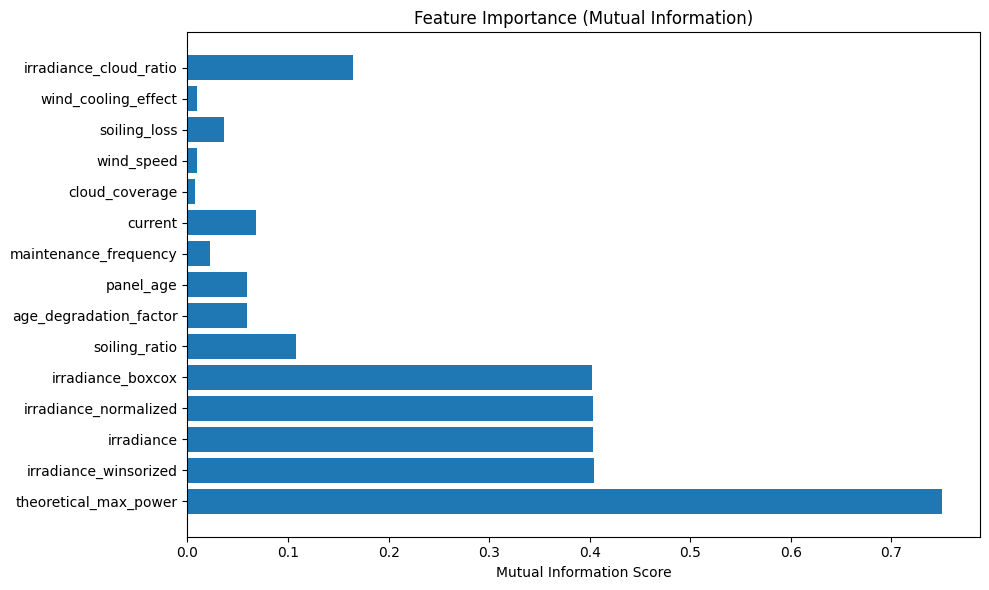

In [44]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt

class AdvancedFeatureSelector:
    def __init__(self):
        self.variance_selector = None
        self.mi_selector = None
        self.f_selector = None
        self.rfecv = None
        self.selected_features = None
        
    def fit(self, X, y, variance_threshold=0.01, k_best=20):
        """
        Complete feature selection pipeline
        """
        print("Starting advanced feature selection...")
        
        # Step 1: Remove low variance features
        self.variance_selector = VarianceThreshold(threshold=variance_threshold)
        X_variance = self.variance_selector.fit_transform(X)
        variance_features = X.columns[self.variance_selector.get_support()]
        print(f"After variance threshold: {len(variance_features)} features")
        
        # Step 2: Univariate feature selection (Mutual Information)
        self.mi_selector = SelectKBest(score_func=mutual_info_regression, k=min(k_best, len(variance_features)))
        X_mi = self.mi_selector.fit_transform(X_variance, y)
        mi_mask = self.mi_selector.get_support()
        mi_features = variance_features[mi_mask]
        print(f"After mutual information: {len(mi_features)} features")
        
        # Step 3: Tree-based feature importance
        tree_selector = ExtraTreesRegressor(n_estimators=100, random_state=42)
        tree_selector.fit(X_mi, y)
        
        # Get feature importances
        importances = tree_selector.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Select top features based on importance
        top_k = min(15, len(mi_features))
        important_indices = indices[:top_k]
        self.selected_features = mi_features[important_indices]
        
        print(f"Final selected features: {len(self.selected_features)}")
        return self.selected_features
    
    def transform(self, X):
        """Transform new data using selected features"""
        if self.selected_features is None:
            raise ValueError("Must call fit() first")
        return X[self.selected_features]
    
    def plot_feature_importance(self, X, y):
        """Plot feature importance scores"""
        if self.selected_features is None:
            raise ValueError("Must call fit() first")
            
        # Calculate mutual information scores for selected features
        mi_scores = mutual_info_regression(X[self.selected_features], y)
        
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(self.selected_features)), mi_scores)
        plt.yticks(range(len(self.selected_features)), self.selected_features)
        plt.xlabel('Mutual Information Score')
        plt.title('Feature Importance (Mutual Information)')
        plt.tight_layout()
        plt.show()

# Use the advanced selector
selector = AdvancedFeatureSelector()
selected_features = selector.fit(X_processed, y, variance_threshold=0.01, k_best=25)

print("\nFinal selected features:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

# Transform your data to use only selected features
X_final = selector.transform(X_processed)
print(f"\nFinal dataset shape: {X_final.shape}")

# Plot feature importance
selector.plot_feature_importance(X_processed, y)
 